In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import math
from datetime import date
from IPython.display import display, HTML
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_rows", 100, "display.max_columns", 100)
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def p(s):
    print(s)
    
pd.DataFrame.len = pd.Index.len = lambda x: print(len(x))

In [2]:
def graphRes(act, pred):
    ax = plt.gca()
    for pos in positions:
        ax.scatter(act[pos],pred[pos], label=f'{pos} ({r2_score(act[pos], pred[pos]).round(2)})')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(labels)
    ax.plot(act['QB'],act['QB'],color='black') # y==x reference line
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

def printStats(y_dev, y_pred):
    # Adapt multioutput back to fan. pts.
    act = {}
    pred = {}
    dfPred = {}
    for pos in positions:
        act[pos] = y_dev[pos].fanPts
        dfPred[pos] = pd.DataFrame(y_pred[pos], columns = y_dev[pos].columns)
        ppr = 0
        if pos != 'QB':
            pred[pos] = dfPred[pos].yards_gained_seasonTotal/10 \
                            + 6 * (dfPred[pos].pass_touchdown_seasonTotal + dfPred[pos].rush_touchdown_seasonTotal) \
                            - 2 * dfPred[pos].fumble_seasonTotal \
                            + ppr * dfPred[pos].complete_pass_seasonTotal
        else:
            pred[pos] = dfPred[pos].yards_gained_seasonTotal/25 \
                            + 4 * dfPred[pos].pass_touchdown_seasonTotal \
                            + 6 * dfPred[pos].rush_touchdown_seasonTotal \
                            - 2 * dfPred[pos].fumble_seasonTotal \
                            - 2 * dfPred[pos].interception_seasonTotal

    graphRes(act, pred)

    stats = pd.DataFrame(index = [positions], columns = ['MAE','RMSE','R^2'])
    for pos in positions:
        stats.loc[pos,'MAE'] = mean_absolute_error(act[pos], pred[pos]).round(1)
        stats.loc[pos,'RMSE'] = round(math.sqrt(mean_squared_error(act[pos], pred[pos])),1)
        stats.loc[pos,'R^2'] = r2_score(act[pos], pred[pos]).round(2)
    
    display(stats)
    

In [3]:
# Partition training, dev, and test data
positions = ['QB','RB','WR','TE']
tgtCols = ['yards_gained_seasonTotal','complete_pass_seasonTotal', 'fumble_seasonTotal','rush_touchdown_seasonTotal','pass_touchdown_seasonTotal','interception_seasonTotal','fanPts']

X_train, X_dev, X_test = {}, {}, {}
y_train, y_dev, y_test = {}, {}, {}
data = {}
X = {}
y = {}
for pos in positions:
    data[pos] = pd.read_csv(f'../expanded/{pos}.csv').dropna(subset=['fanPts'])
        
    # Split into features and targets
    X[pos] = data[pos].loc[:,data[pos].columns.str.contains('-\d+') | data[pos].columns.str.match('fanPts')] \
        .drop('fanPts',axis=1) \
        .fillna(0)
    y[pos] = data[pos].loc[:,[x for x in tgtCols if x in data[pos].columns]]
    
    # Downselect useful X features
    featureInfo = pd.read_csv('../features.csv').iloc[:,0:-9]
    featureInfo = featureInfo.loc[featureInfo['Use']==1,:]
    featMap = {'QB':'Pass','RB':'Rush','WR':'Rec','TE':'Rec'}
    X[pos] = X[pos].loc[:,[x for x in X[pos].columns if any([x.startswith(y) for y in featureInfo[featureInfo[featMap[pos]] == 1].Field.tolist()])]]
    
        
    # Split train/dev/test
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X[pos], y[pos], test_size=0.3, random_state=0)
    X_dev_raw, X_test_raw, y_dev_raw, y_test_raw = train_test_split(X_test_raw, y_test_raw, test_size=0.5, random_state=0)
    
    # Scale X data
    ss = preprocessing.StandardScaler()
    X_train[pos] = pd.DataFrame(ss.fit_transform(X_train_raw), columns=X_train_raw.columns)
    X_dev[pos] = pd.DataFrame(ss.fit_transform(X_dev_raw), columns=X_dev_raw.columns)
    X_test[pos] = pd.DataFrame(ss.fit_transform(X_test_raw), columns=X_test_raw.columns)
    
    # Leave y data in original units
    y_train[pos] = y_train_raw
    y_dev[pos] = y_dev_raw
    y_test[pos] = y_test_raw

QB: 0.3539826086431304 oob score
RB: 0.3283944751522811 oob score
WR: 0.23233532877436236 oob score
TE: 0.23618761539151242 oob score


,MAE,RMSE,R^2
QB,50.700,73.200,0.480
RB,37.400,59.600,0.330
WR,35.900,50.100,0.420
TE,22.300,30.300,0.350


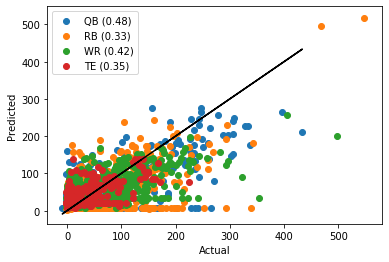

In [4]:
y_pred = {}
for pos in positions:
    m = m = RandomForestRegressor(oob_score = True)
    m.fit(X_train[pos],y_train[pos])
    y_pred[pos] = m.predict(X_dev[pos])
    
    print(f'{pos}: {m.oob_score_} oob score')
    
printStats(y_dev, y_pred)

QB: 0.34523989955580536 oob score
{'max_depth': 3, 'n_estimators': 30}

RB: 0.32739263357129367 oob score
{'max_depth': 6, 'n_estimators': 20}

WR: 0.2351034685974057 oob score
{'max_depth': 5, 'n_estimators': 70}

TE: 0.2335761514349672 oob score
{'max_depth': 3, 'n_estimators': 20}



,MAE,RMSE,R^2
QB,50.500,72.100,0.490
RB,37.900,59.900,0.320
WR,35.900,50.600,0.400
TE,21.900,30.200,0.360


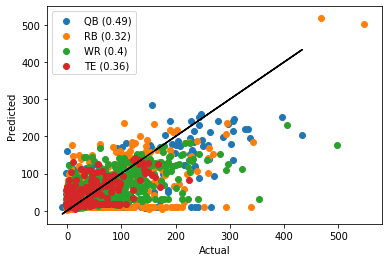

In [5]:
y_pred = {}
bestParams = {}
for pos in positions:
    
    grid = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid = {
            'max_depth': range(1,10),
            'n_estimators': tuple(list(range(10,100,10)) + [500, 1000]),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1).fit(X_train[pos],y_train[pos])
    
    bestParams[pos] = grid.best_params_
    
    rfr = RandomForestRegressor(max_depth=bestParams[pos]["max_depth"], n_estimators=bestParams[pos]["n_estimators"], oob_score = True, random_state=False, verbose=False)
    m.fit(X_train[pos],y_train[pos])
    y_pred[pos] = m.predict(X_dev[pos])
    
    print(f'{pos}: {m.oob_score_} oob score')
    print(f'{bestParams[pos]}\n')
    
printStats(y_dev,y_pred)